In [ ]:
!pip install dask dask[dataframe] dask-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 7.4 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[########################################] | 100% Completed | 4.46 s
[########################################] | 100% Completed | 4.06 s
[########################################] | 100% Completed | 4.10 s
[########################################] | 100% Completed | 4.24 s
[########################################] | 100% Completed | 4.11 s
[########################################] | 100% Completed | 4.59 s
[########################################] | 100% Completed | 4.23 s
[########################################] | 100% Completed | 4.24 s
[########################################] | 100% Completed | 4.14 s
[########################################] | 100% Completed | 4.15 s
[########################################] | 100% Completed | 71.41 s
[########################################] | 100% Completed | 69.79 s
Dados carregados e pré-processados com su

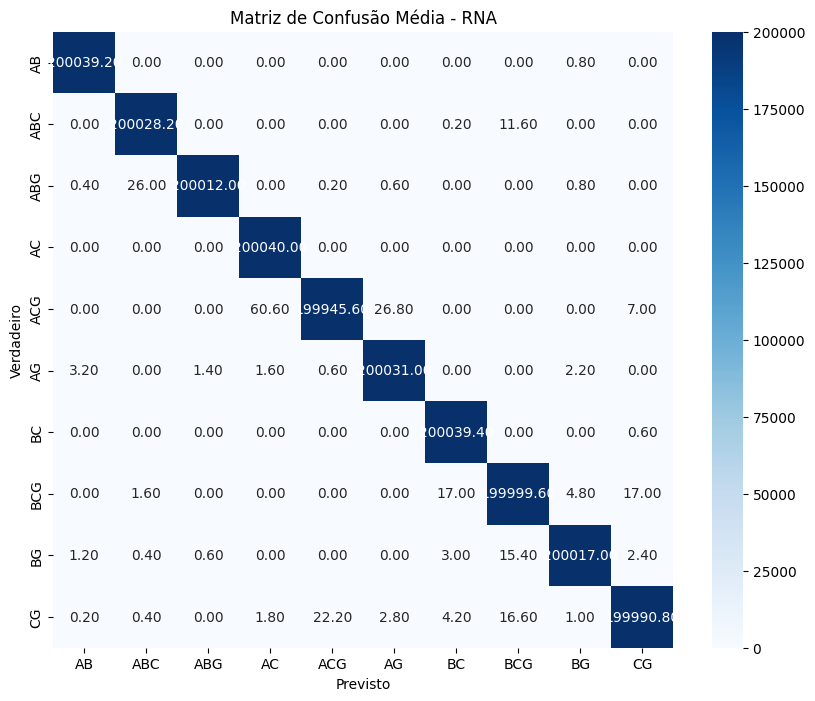

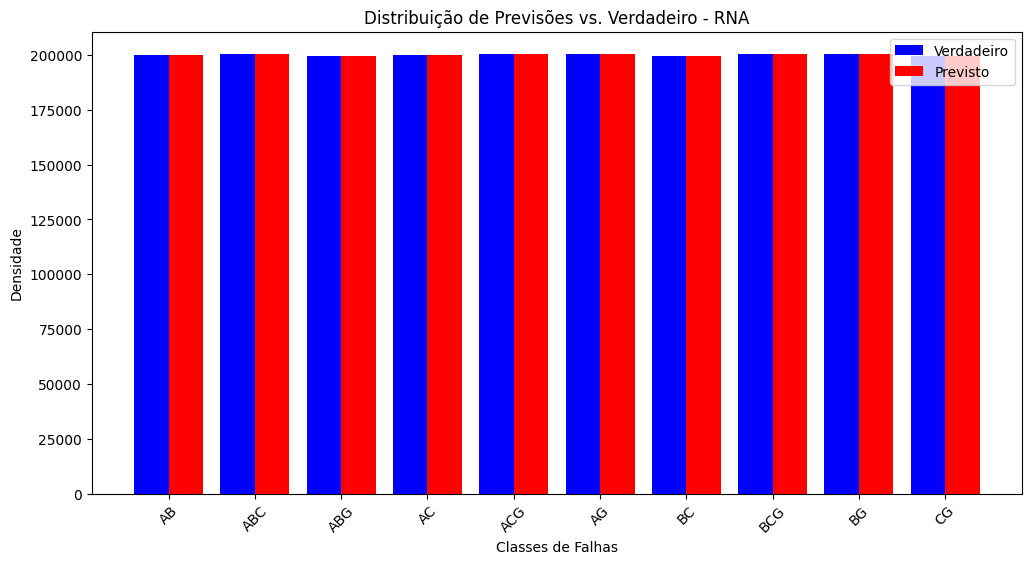

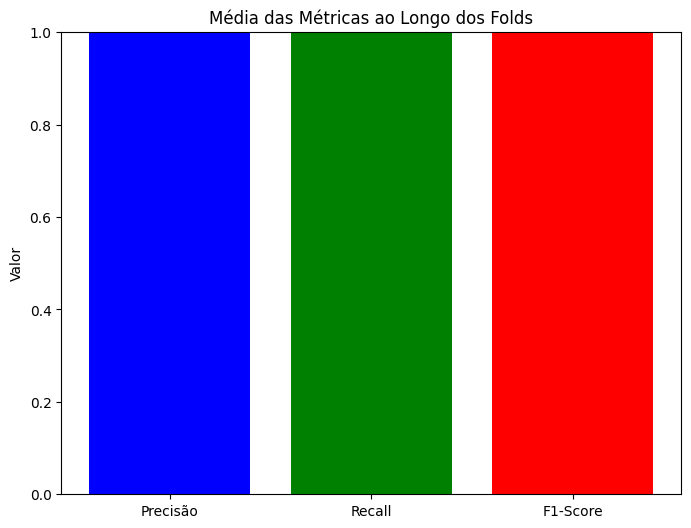

In [ ]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

# Monta o Google Drive
drive.mount('/content/drive')

# Função para carregar dados usando Dask
def load_data(filepath, cols_to_use):
    df = dd.read_csv(filepath, usecols=cols_to_use)
    df = df.drop_duplicates().map_partitions(lambda x: x.apply(lambda col: col.str.strip() if col.dtype == "object" else col))
    return df

# Função para pré-processar os dados com Dask
def preprocess_data(df):
    scaler = DaskScaler()
    df = scaler.fit_transform(df)
    return df

# Função para detectar e tratar anomalias
def detect_and_treat_anomalies(df):
    z_scores = ((df - df.mean()) / df.std()).abs()
    df = df[(z_scores < 3).all(axis=1)].dropna()  # Remove valores com z-score > 3
    return df

# Função para adicionar rótulo com base na pasta
def add_labels(df, label):
    df['label'] = label
    return df

# Função para balancear classes usando SMOTE diretamente
def balance_classes(X, y):
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X.compute(), y.compute())
    return X_res, y_res

# Processamento dos arquivos usando Dask
def process_files_in_folder_dask(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    if not files:
        return pd.DataFrame(), pd.Series()  # Retorna DataFrame e Series vazios se não houver arquivos
    df = dd.concat([load_data(file, cols_to_use) for file in files], axis=0)
    df = preprocess_data(df)
    df = detect_and_treat_anomalies(df)
    df = add_labels(df, label)
    return df.drop('label', axis=1), df['label']

# Processamento paralelo usando Dask
def process_all_folders_dask(base_path, subfolders):
    X_list = []
    y_list = []
    for subfolder in subfolders:
        folder_path = os.path.join(base_path, subfolder)
        X, y = process_files_in_folder_dask(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                          'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                          'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], subfolder)

        if X.npartitions > 0:
            X_list.append(X)
            y_list.append(y)

    if X_list:
        X_final = dd.concat(X_list) # Concatenate Dask DataFrames
        y_final = dd.concat(y_list)
        return balance_classes(X_final, y_final)
    else:
        return pd.DataFrame(), pd.Series()  # Retorna DataFrame e Series vazios se não houver dados

# Chamada principal
base_path = '/content/drive/MyDrive/Amostra'
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']

with ProgressBar():
    X, y = process_all_folders_dask(base_path, subfolders)

# Convertendo para pandas DataFrame e Series
X = pd.DataFrame(X)
y = pd.Series(y)

print("Dados carregados e pré-processados com sucesso!")

# Codificação de rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Definindo o modelo de RNA
def RNA_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Preparando a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_idx = 1
results = []
conf_matrices = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Convertendo os dados para float32 para compatibilidade com TensorFlow
    X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
    y_train, y_test = y_train.astype('int32'), y_test.astype('int32')

    num_classes = len(np.unique(y_train))
    model = RNA_model(X_train.shape[1:], num_classes)

    # Treinamento do modelo
    start_time = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    training_time = time.time() - start_time

    # Avaliação do modelo
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Métricas
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append((training_time, precision, recall, f1))
    conf_matrices.append(conf_matrix)

    print(f"Fold {fold_idx}: Tempo de treinamento {training_time:.2f} s, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    fold_idx += 1

# Média das métricas
avg_training_time = np.mean([result[0] for result in results])
avg_precision = np.mean([result[1] for result in results])
avg_recall = np.mean([result[2] for result in results])
avg_f1 = np.mean([result[3] for result in results])

print(f"Média Tempo de treinamento: {avg_training_time:.2f} s")
print(f"Média Precisão: {avg_precision:.4f}")
print(f"Média Recall: {avg_recall:.4f}")
print(f"Média F1-Score: {avg_f1:.4f}")

# Matriz de Confusão Média
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Plot da Matriz de Confusão
plt.figure(figsize=(10, 8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Matriz de Confusão Média - RNA')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

# Plot do histograma para o último fold
def plot_predictions_vs_true(y_test, y_pred):
    categories = label_encoder.classes_
    plt.figure(figsize=(12, 6))
    bins = np.arange(len(categories) + 1) - 0.5
    plt.hist([y_test, y_pred], bins=bins, color=['blue', 'red'], label=['Verdadeiro', 'Previsto'], align='mid', rwidth=0.8)
    plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    plt.title('Distribuição de Previsões vs. Verdadeiro - RNA')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

# Chamando a função de plotagem para o último fold processado
plot_predictions_vs_true(y_test, y_pred)

# Gráfico de barras das médias das métricas
metrics = ['Precisão', 'Recall', 'F1-Score']
values = [avg_precision, avg_recall, avg_f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Média das Métricas ao Longo dos Folds')
plt.ylabel('Valor')
plt.show()
